In [1]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.morningstar import Fundamentals as Fundamentals_m
from quantopian.pipeline.domain import US_EQUITIES
from quantopian.research import run_pipeline
from quantopian.research import prices
import alphalens as al
from alphalens.tears import create_returns_tear_sheet
from alphalens.tears import create_information_tear_sheet
from quantopian.pipeline.data import factset
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals
MAX_GROSS_LEVERAGE = 1.0
TOTAL_POSITIONS = 600

In [5]:
def make_pipeline():
    
    #treasury_stock = Fundamentals_m.treasury_stock.latest # Desperate
    #treasury_stock = treasury_stock.winsorize(min_percentile=0.05, max_percentile=0.95)
    
    free_cash_flows = Fundamentals_m.net_income_income_statement.latest # Desperate
    free_cash_flows = free_cash_flows.winsorize(min_percentile=0.05, max_percentile=0.95)
    
    universe = QTradableStocksUS()
    
    combined_factor = (
        #treasury_stock
        free_cash_flows
        
    )

    longs = combined_factor.top(TOTAL_POSITIONS//2, mask=universe)
    shorts = combined_factor.bottom(TOTAL_POSITIONS//2, mask=universe)

    long_short_screen = (longs | shorts)

    # Create pipeline
    pipe = Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'combined_factor': combined_factor
        },
        screen=long_short_screen
    )
    return pipe

Dropped 10.4% entries from factor data: 10.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.011,0.013,0.010
IC Std.,0.152,0.135,0.129
Risk-Adjusted IC,0.071,0.095,0.080
t-stat(IC),0.696,0.928,0.780
p-value(IC),0.488,0.356,0.437
IC Skew,0.019,0.371,0.696
IC Kurtosis,-0.840,-0.191,-0.018


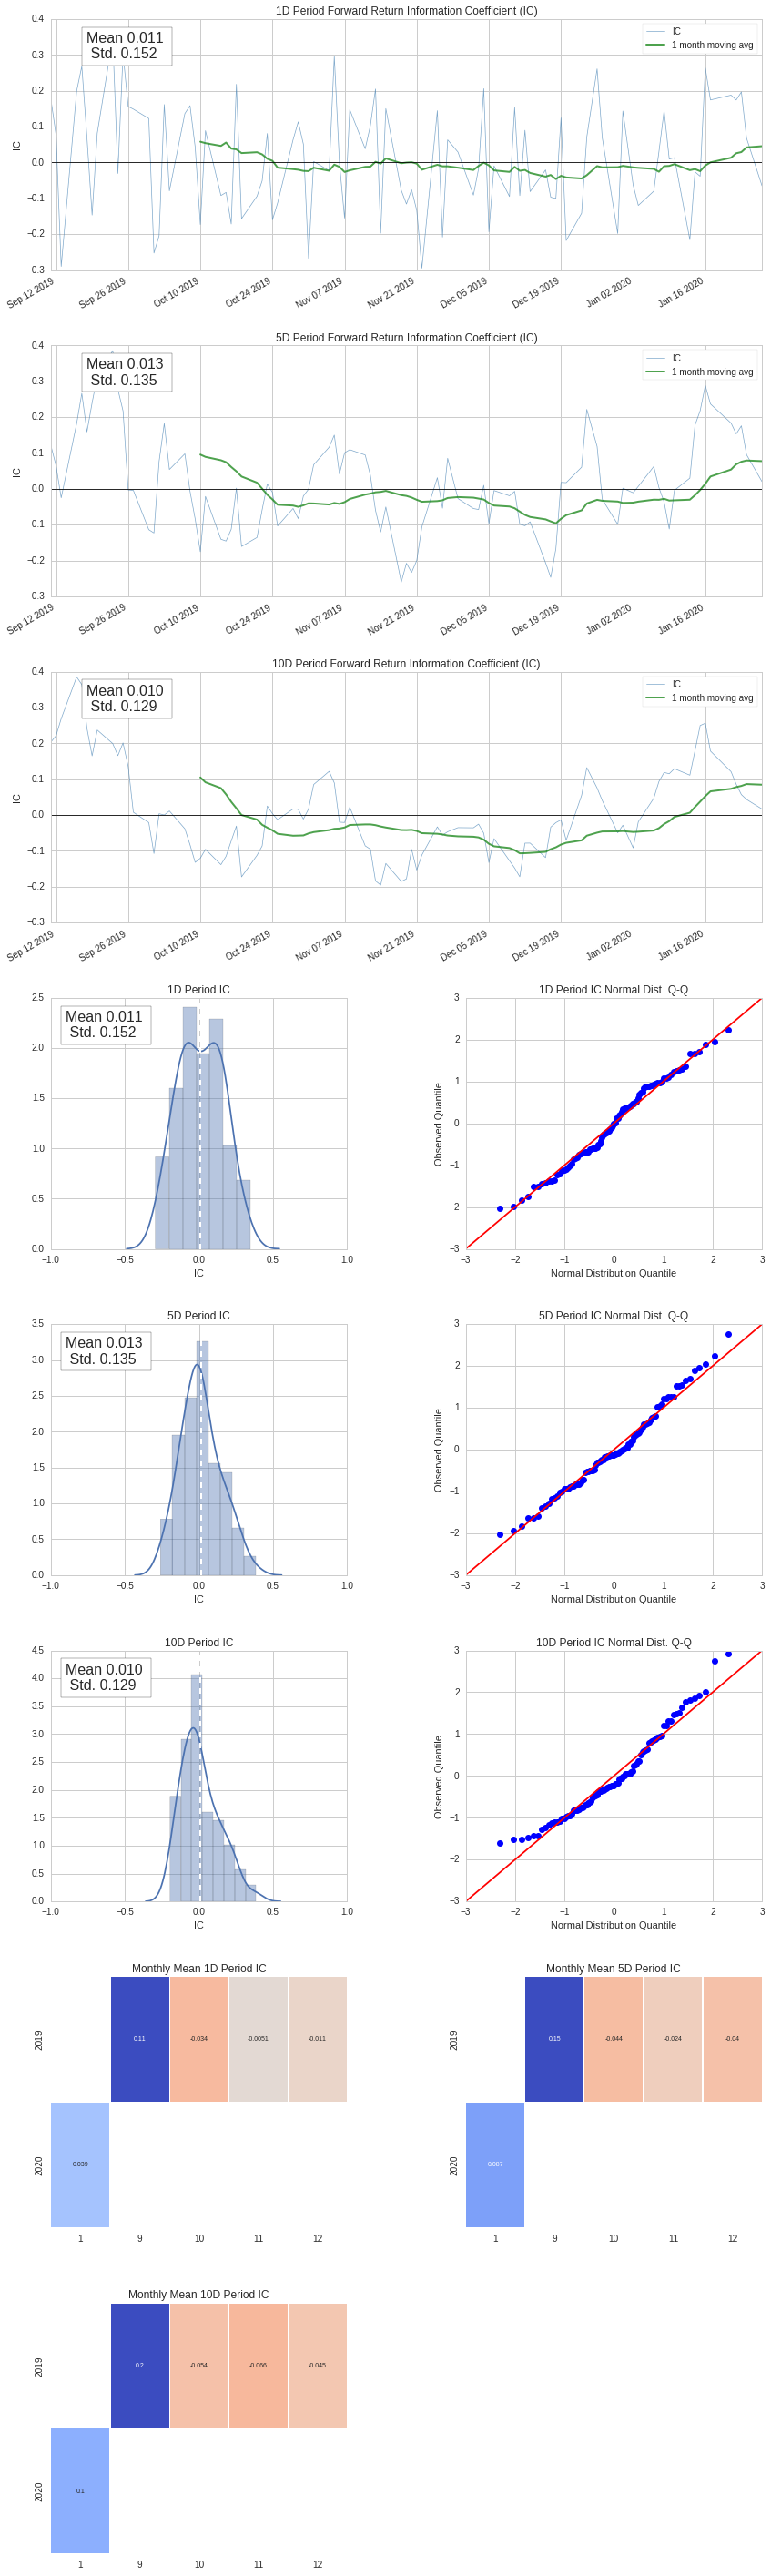

In [6]:
today = "2/11/2020"
six_months_before="9/11/2019"
two_years ="2/11/2018"

pipeline_output = run_pipeline(
    make_pipeline(),
    start_date= six_months_before,
    end_date=today
)

asset_list = pipeline_output.index.levels[1].unique()
asset_prices = prices(
    asset_list,
    start=six_months_before,
    end=today
)
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['combined_factor'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,5,10),
)
create_information_tear_sheet(factor_data)

Dropped 2.2% entries from factor data: 2.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.010,0.024,0.033
IC Std.,0.160,0.150,0.142
Risk-Adjusted IC,0.062,0.159,0.235
t-stat(IC),1.381,3.518,5.208
p-value(IC),0.168,0.000,0.000
IC Skew,0.032,-0.074,-0.181
IC Kurtosis,-0.307,-0.140,0.150


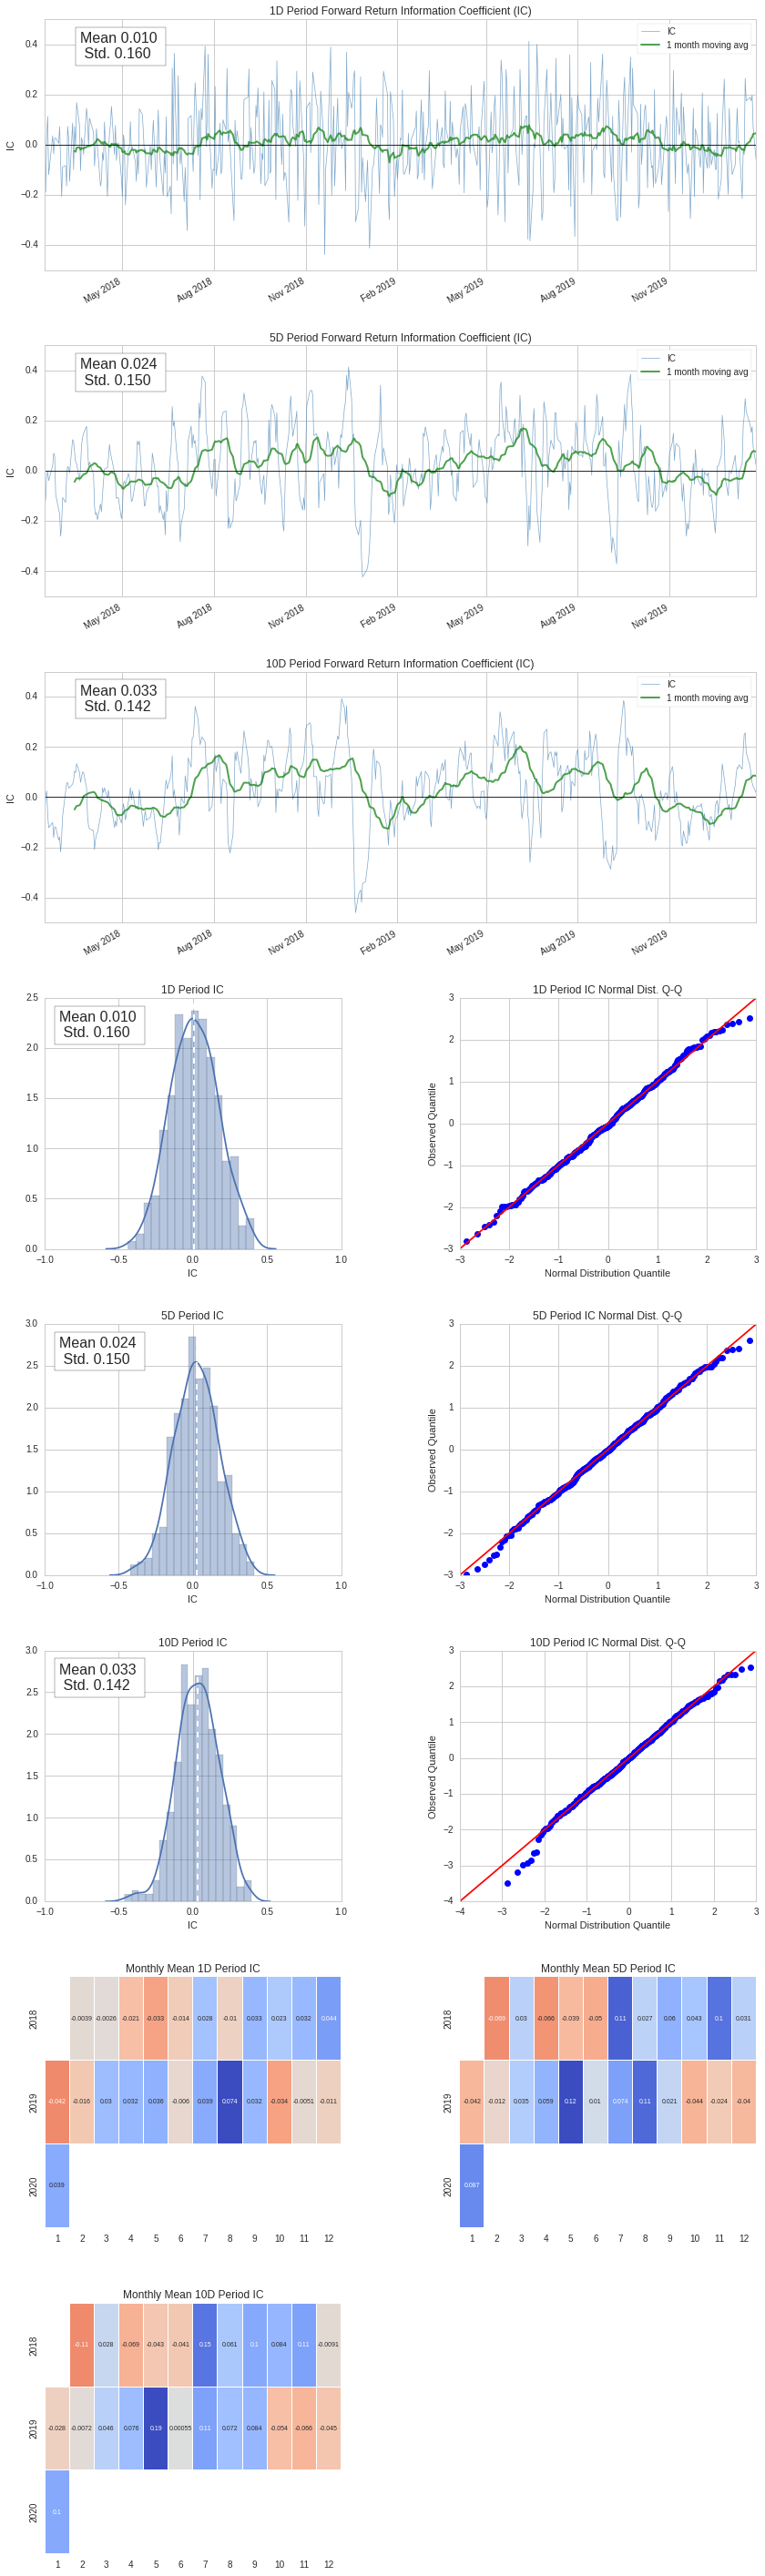

In [7]:
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date= two_years,
    end_date=today
)

asset_list = pipeline_output.index.levels[1].unique()
asset_prices = prices(
    asset_list,
    start=two_years,
    end=today
)
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['combined_factor'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,5,10),
)
create_information_tear_sheet(factor_data)

Returns Analysis


,1D,5D,10D
Ann. alpha,0.053,0.052,0.053
beta,-0.246,-0.269,-0.278
Mean Period Wise Return Top Quantile (bps),1.347,1.380,1.389
Mean Period Wise Return Bottom Quantile (bps),-1.351,-1.384,-1.393
Mean Period Wise Spread (bps),2.697,2.764,2.782


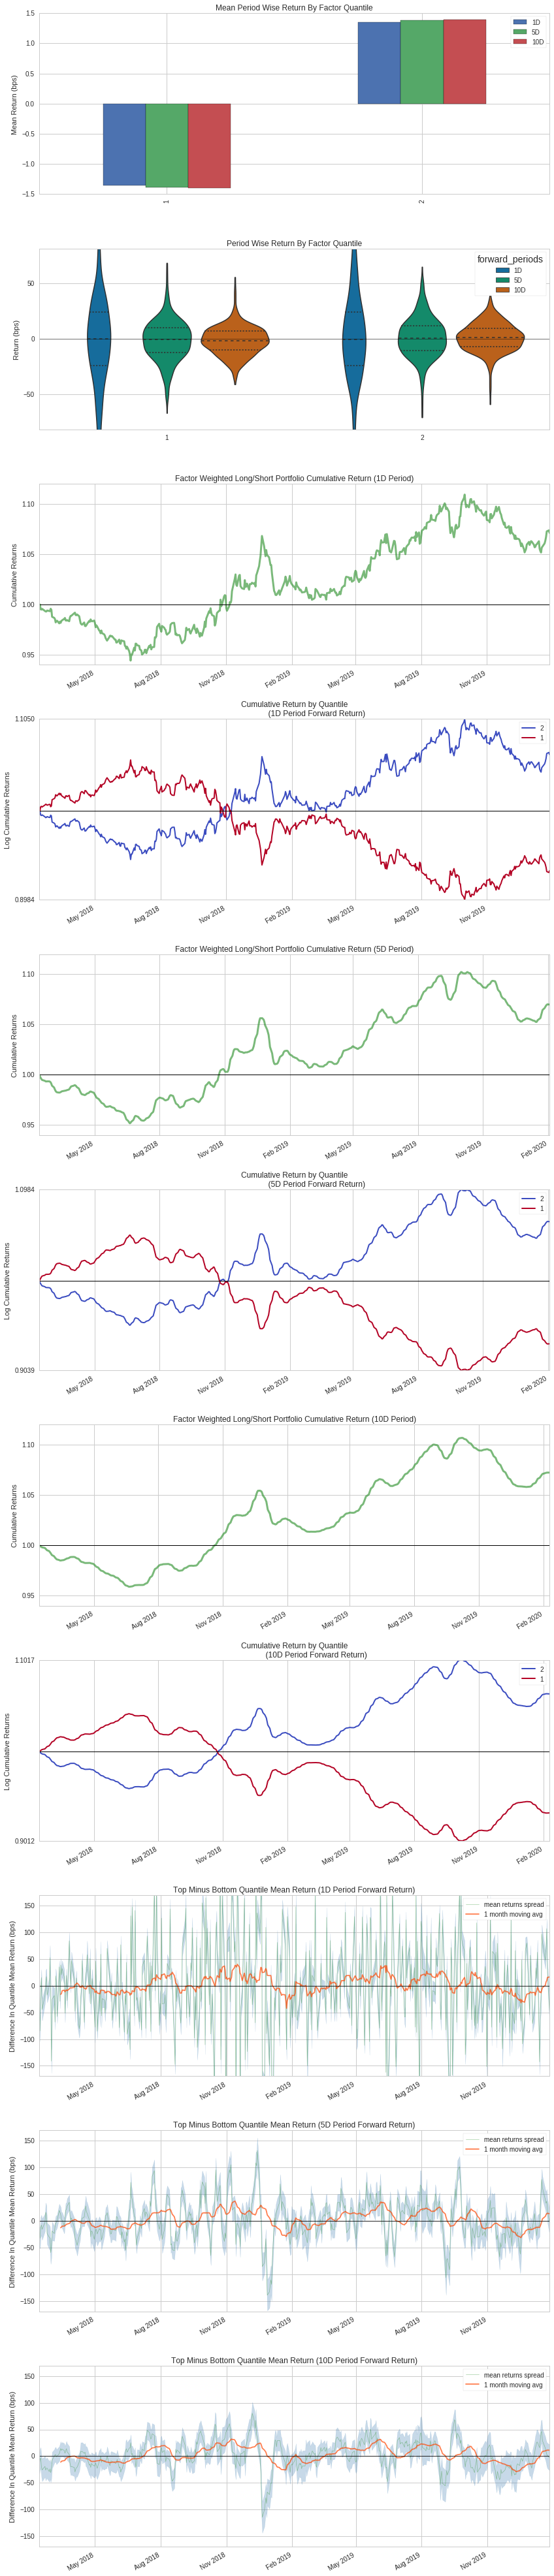

In [8]:
create_returns_tear_sheet(factor_data)